Regression test (Linear vs Polynomial)

This notebook follows the assignment instructions:
- Part 1: Predict **Horse Power (HP)** from fuel-consumption feature(s).
- Part 2: Predict **daily electricity consumption** from weather feature(s).

**How to run:** Put the CSV files in the same folder as this notebook (or update the file paths below), then run **Run All**.

**Resources/Collaboration:** (Fill in if applicable.)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
def prepare_xy(df_in, target_col, feature_cols=None):
    """
    Drop missing rows, split into X and y.
    If feature_cols is None, uses all columns except target.
    """
    df_clean = df_in.dropna().copy()

    if feature_cols:
        X = df_clean[feature_cols]
    else:
        X = df_clean.drop(columns=[target_col])

    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names)."""
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name, top_k_terms=10):
    """Print the top K terms of the fitted equation."""
    try:
        intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

        # Sort by absolute coefficient magnitude
        order = np.argsort(np.abs(coefs))[::-1]
        order = order[:min(top_k_terms, len(coefs))]

        terms = []
        for idx in order:
            terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

        eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)
        print(f"Equation (Top {len(terms)} terms):")
        print(eq)
    except:
        print("Could not extract equation details.")

def plot_actual_vs_predicted(y_test, y_pred, title):
    """Scatter plot of Actual vs Predicted values."""
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.show()

def run_models_and_evaluate(X, y, scenario_name, degrees=(1, 2, 3, 4), test_size=0.30):
    """
    Train/evaluate linear + polynomial regression models.
    Returns a DataFrame of metrics.
    """
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial (deg={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        print(f"\n--- {scenario_name}: {model_name} ---")
        if hasattr(X_train, "columns"):
            print_fitted_equation(model, X_train.columns, y.name)

        # Add to results table
        rows.append({
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R2": test_m["R^2"]
        })

    return pd.DataFrame(rows)

# Part 1: Fuel Consumption → Horse Power Prediction

=== Part 1: Raw dataset inspection ===
Columns: ['Horse Power', 'Fuel Economy (MPG)']
Shape: (100, 2)


,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


,0
Horse Power,0
Fuel Economy (MPG),0



Target (y): Horse Power
Features (X): ['Fuel Economy (MPG)']

Missing-value handling: dropped rows with any missing in selected X/y: 0 rows removed.


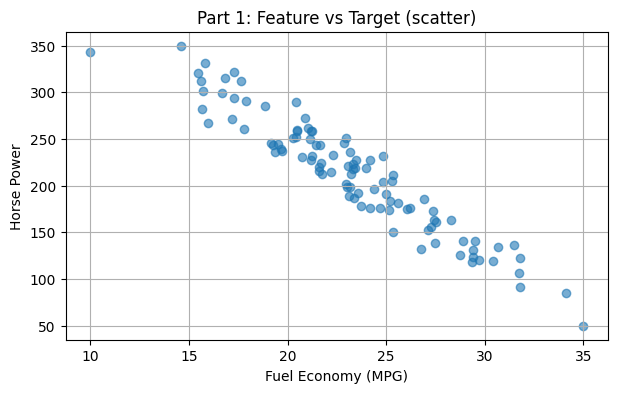

In [6]:
# -----------------------------
# Part 1: Fuel Consumption → Horse Power Prediction
# -----------------------------

# Load dataset
fuel_path = "FuelEconomy.csv"  # update path if needed
df_fuel = pd.read_csv(fuel_path)

print("=== Part 1: Raw dataset inspection ===")
print("Columns:", df_fuel.columns.tolist())
print("Shape:", df_fuel.shape)
display(df_fuel.head())
display(df_fuel.describe(include="all"))

# Missing values report
missing_fuel = df_fuel.isna().sum()
print("\nMissing values per column:")
display(missing_fuel[missing_fuel > 0] if (missing_fuel > 0).any() else missing_fuel)

# Identify target + features
# Target must be horsepower per assignment.
candidate_targets = ["Horse Power", "Horsepower", "HP", "horse_power", "horsepower"]
target_col = next((c for c in candidate_targets if c in df_fuel.columns), None)
if target_col is None:
    raise ValueError(
        f"Could not find horsepower column. Tried: {candidate_targets}. "
        f"Available columns: {df_fuel.columns.tolist()}"
    )

# Fuel-consumption features: use all numeric columns except target (and any obvious non-feature like an ID/name)
non_feature_cols = {target_col}
for c in df_fuel.columns:
    if c.lower() in {"id", "name", "model", "make"}:
        non_feature_cols.add(c)

numeric_cols = df_fuel.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in non_feature_cols]

if len(feature_cols) == 0:
    raise ValueError(
        "No numeric fuel-consumption feature columns found after excluding the target. "
        f"Numeric columns: {numeric_cols}"
    )

print(f"\nTarget (y): {target_col}")
print(f"Features (X): {feature_cols}")

# Prepare X and y (drop rows with missing values in X or y)
rows_before = len(df_fuel)
X_fuel, y_fuel = prepare_xy(df_fuel, target_col=target_col, feature_cols=feature_cols)
rows_after = len(y_fuel)
print(f"\nMissing-value handling: dropped rows with any missing in selected X/y: {rows_before - rows_after} rows removed.")

# Quick visualization (univariate scatter if only one feature)
if X_fuel.shape[1] == 1:
    xname = X_fuel.columns[0]
    plt.figure(figsize=(7, 4))
    plt.scatter(X_fuel[xname], y_fuel, alpha=0.6)
    plt.xlabel(xname)
    plt.ylabel(target_col)
    plt.title("Part 1: Feature vs Target (scatter)")
    plt.grid(True)
    plt.show()
else:
    # Show correlation heatmap to understand relationships
    corr = pd.concat([X_fuel, y_fuel], axis=1).corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Part 1: Correlation (numeric columns)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [7]:
# Train/evaluate models (70/30 split with fixed random state is inside split_data)
results_fuel = run_models_and_evaluate(
    X_fuel,
    y_fuel,
    scenario_name="Part 1 (Fuel → HP)",
    degrees=(1, 2, 3, 4)
)

print("\n=== Model Performance Summary (Part 1) ===")
display(results_fuel)



--- Part 1 (Fuel → HP): Linear Regression ---
Equation (Top 1 terms):
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)

--- Part 1 (Fuel → HP): Polynomial (deg=2) ---
Equation (Top 2 terms):
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2

--- Part 1 (Fuel → HP): Polynomial (deg=3) ---
Equation (Top 3 terms):
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3

--- Part 1 (Fuel → HP): Polynomial (deg=4) ---
Equation (Top 4 terms):
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4

=== Model Performance Summary (Part 1) ===


,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561
1,Polynomial (deg=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118
2,Polynomial (deg=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604
3,Polynomial (deg=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868


In [8]:
# -----------------------------
# Part 1 Discussion (auto-filled from your computed metrics)
# -----------------------------
# Choose best model by lowest Test MSE (you can also compare by Test R2)
best_idx = results_fuel["Test MSE"].astype(float).idxmin()
best_row = results_fuel.loc[best_idx]

# Detect overfitting pattern: train error down while test error up as degree increases
deg_order = ["Linear Regression", "Polynomial Regression (deg=2)", "Polynomial Regression (deg=3)", "Polynomial Regression (deg=4)"]
df_ordered = results_fuel.set_index("Model").reindex(deg_order)

def _fmt(x):
    try:
        return f"{float(x):.4g}"
    except Exception:
        return str(x)

best_model = best_row["Model"]
best_test_mse = _fmt(best_row["Test MSE"])
best_test_mae = _fmt(best_row["Test MAE"])
best_test_r2  = _fmt(best_row["Test R2"])

# Simple heuristic for "good" performance (you can adjust): R2 >= 0.7
best_r2_val = float(best_row["Test R2"])
needs_reasons = best_r2_val < 0.7

reasons = [
    "Possible underfitting or overfitting (degree too low/high), shown by gaps between train and test metrics.",
    "The fuel-consumption feature set may not contain enough information to predict HP accurately (missing variables like vehicle weight, engine size, transmission, etc.).",
    "Outliers / measurement noise can inflate test error and reduce R².",
    "Nonlinear or segmented relationships (different vehicle classes) may not be captured well by a single global polynomial."
]

md_lines = []
md_lines.append("## Part 1 Discussion")
md_lines.append(f"**Best model on the test set:** `{best_model}` "
                f"(Test MSE={best_test_mse}, Test MAE={best_test_mae}, Test R²={best_test_r2}).")
md_lines.append("")
md_lines.append("**Does increasing polynomial degree always help?** "
                "Compare the Test metrics across degrees in the table. "
                "If higher-degree models reduce Train error but worsen Test error, that is evidence of overfitting.")
md_lines.append("")
if needs_reasons:
    md_lines.append("**If performance is not strong (e.g., lower Test R²): two plausible reasons**")
    md_lines.append(f"- {reasons[0]}")
    md_lines.append(f"- {reasons[1]}")
    md_lines.append("")
    md_lines.append("Additional plausible reasons:")
    md_lines.append(f"- {reasons[2]}")
    md_lines.append(f"- {reasons[3]}")
else:
    md_lines.append("**Why the best model is best:** it achieves the lowest Test error (and/or highest Test R²) while keeping Train and Test performance reasonably close (good generalization).")

display(Markdown("\n".join(md_lines)))


## Part 1 Discussion
**Best model on the test set:** `Polynomial (deg=4)` (Test MSE=313.8, Test MAE=14.74, Test R²=0.9139).

**Does increasing polynomial degree always help?** Compare the Test metrics across degrees in the table. If higher-degree models reduce Train error but worsen Test error, that is evidence of overfitting.

**Why the best model is best:** it achieves the lowest Test error (and/or highest Test R²) while keeping Train and Test performance reasonably close (good generalization).

# Part 2: Weather → Daily Electricity Consumption Prediction

=== Part 2: Raw dataset inspection ===
Columns: ['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']
Shape: (1433, 6)


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Dependent variable (y): daily_consumption

Missing values per column:


,0
AWND,15


Weather features (X): ['AWND', 'PRCP', 'TMAX', 'TMIN']

Missing-value handling: dropped rows with any missing in selected X/y: 15 rows removed.


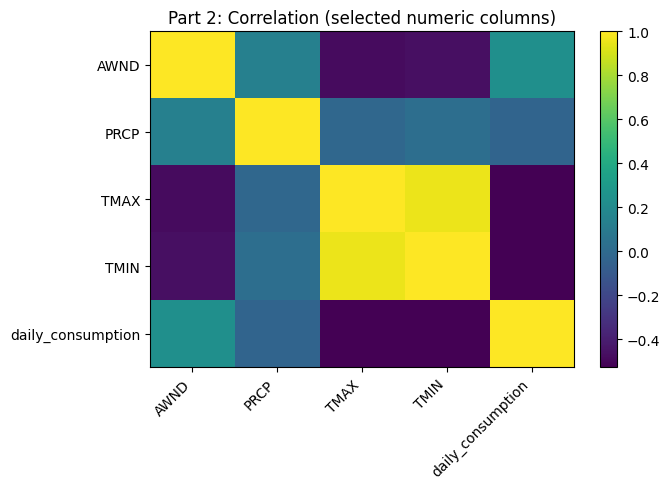

In [9]:
# -----------------------------
# Part 2: Weather → Daily Electricity Consumption Prediction
# -----------------------------

elec_path = "electricity_consumption_based_weather_dataset.csv"  # update path if needed
df_elec = pd.read_csv(elec_path)

print("=== Part 2: Raw dataset inspection ===")
print("Columns:", df_elec.columns.tolist())
print("Shape:", df_elec.shape)
display(df_elec.head())
display(df_elec.describe(include="all"))

# Identify dependent variable (daily consumption) per assignment
candidate_targets = ["daily_consumption", "Daily Consumption", "consumption", "electricity_consumption", "energy_consumption"]
target_col_elec = next((c for c in candidate_targets if c in df_elec.columns), None)
if target_col_elec is None:
    raise ValueError(
        f"Could not find daily consumption column. Tried: {candidate_targets}. "
        f"Available columns: {df_elec.columns.tolist()}"
    )
print(f"\nDependent variable (y): {target_col_elec}")

# Missing values report
missing_elec = df_elec.isna().sum()
print("\nMissing values per column:")
display(missing_elec[missing_elec > 0] if (missing_elec > 0).any() else missing_elec)

# Choose weather features:
# Prefer common weather columns if present; otherwise use all numeric columns excluding target and obvious non-features.
preferred_weather = ["AWND", "PRCP", "TMAX", "TMIN"]
feature_cols_elec = [c for c in preferred_weather if c in df_elec.columns]

if len(feature_cols_elec) == 0:
    # Fall back to all numeric columns except target (and date-like columns)
    non_feature = {target_col_elec}
    for c in df_elec.columns:
        if c.lower() in {"date", "day", "time", "timestamp"}:
            non_feature.add(c)
    numeric_cols = df_elec.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols_elec = [c for c in numeric_cols if c not in non_feature]

if len(feature_cols_elec) == 0:
    raise ValueError("No numeric weather feature columns found.")

print(f"Weather features (X): {feature_cols_elec}")

# Prepare X and y (drop rows with missing values in selected X/y)
rows_before = len(df_elec)
X_elec, y_elec = prepare_xy(df_elec, target_col=target_col_elec, feature_cols=feature_cols_elec)
rows_after = len(y_elec)
print(f"\nMissing-value handling: dropped rows with any missing in selected X/y: {rows_before - rows_after} rows removed.")

# Correlation view (numeric only)
corr_cols = feature_cols_elec + [target_col_elec]
corr = df_elec[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(7, 5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Part 2: Correlation (selected numeric columns)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [10]:
results_elec = run_models_and_evaluate(
    X_elec,
    y_elec,
    scenario_name="Part 2 (Weather → Daily Consumption)",
    degrees=(1, 2, 3, 4)
)

print("\n=== Model Performance Summary (Part 2) ===")
display(results_elec)



--- Part 2 (Weather → Daily Consumption): Linear Regression ---
Equation (Top 4 terms):
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP

--- Part 2 (Weather → Daily Consumption): Polynomial (deg=2) ---
Equation (Top 10 terms):
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP

--- Part 2 (Weather → Daily Consumption): Polynomial (deg=3) ---
Equation (Top 10 terms):
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3

--- Part 2 (Weather → Daily Consumption): Polynomial (deg=4) ---
Equation (Top 10 terms):
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) 

,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333
1,Polynomial (deg=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163
2,Polynomial (deg=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922
3,Polynomial (deg=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844


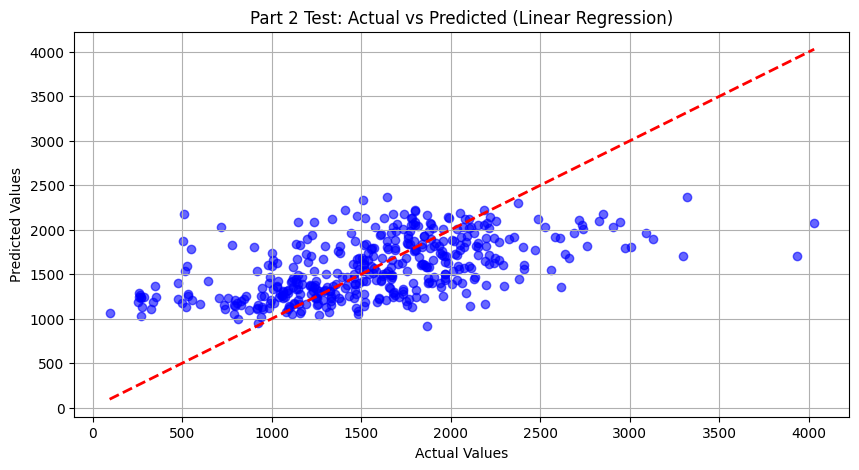

## Part 2 Discussion
**Best generalizing model (test set):** `Linear Regression` (Test MSE=2.481e+05, Test MAE=375.4, Test R²=0.2993).

**Do polynomial models improve fit vs linear?** Check whether Test error decreases (and/or Test R² increases) as degree increases. If improvement exists, it suggests a nonlinear relationship between weather variables and electricity usage.

**If higher-degree models perform worse on the test set:** that is classic overfitting: Train error goes down, but Test error goes up.

**If test performance is not strong: two plausible reasons (supported by outputs)**
- Weather alone may not explain daily consumption well; unmodeled drivers like occupancy/behavior, holidays, pricing, and industrial activity can dominate.
- Strong seasonal/time effects (date/weekday) are not included as features, which can limit predictability even if weather is measured accurately.

In [11]:
# Plot Actual vs Predicted for the best Part 2 model (based on Test MSE)
best_idx2 = results_elec["Test MSE"].astype(float).idxmin()
best_row2 = results_elec.loc[best_idx2]
best_model_name2 = best_row2["Model"]

# Map model name to polynomial degree
name_to_degree = {
    "Linear Regression": 1,
    "Polynomial Regression (deg=2)": 2,
    "Polynomial Regression (deg=3)": 3,
    "Polynomial Regression (deg=4)": 4,
}
best_deg2 = name_to_degree.get(best_model_name2, 1)

# Re-split once (fixed random state inside split_data) and fit the chosen best model
X_train_e, X_test_e, y_train_e, y_test_e = split_data(X_elec, y_elec)

if best_deg2 == 1:
    model_best2 = LinearRegression()
else:
    model_best2 = Pipeline([
        ("poly", PolynomialFeatures(degree=best_deg2, include_bias=False)),
        ("lr", LinearRegression())
    ])

model_best2.fit(X_train_e, y_train_e)
y_pred_e = model_best2.predict(X_test_e)

plot_actual_vs_predicted(y_test_e, y_pred_e, f"Part 2 Test: Actual vs Predicted ({best_model_name2})")

# -----------------------------
# Part 2 Discussion (auto-filled from metrics)
# -----------------------------
best_test_mse2 = _fmt(best_row2["Test MSE"])
best_test_mae2 = _fmt(best_row2["Test MAE"])
best_test_r2_2 = _fmt(best_row2["Test R2"])

best_r2_val2 = float(best_row2["Test R2"])
needs_reasons2 = best_r2_val2 < 0.7

md2 = []
md2.append("## Part 2 Discussion")
md2.append(f"**Best generalizing model (test set):** `{best_model_name2}` "
           f"(Test MSE={best_test_mse2}, Test MAE={best_test_mae2}, Test R²={best_test_r2_2}).")
md2.append("")
md2.append("**Do polynomial models improve fit vs linear?** "
           "Check whether Test error decreases (and/or Test R² increases) as degree increases. "
           "If improvement exists, it suggests a nonlinear relationship between weather variables and electricity usage.")
md2.append("")
md2.append("**If higher-degree models perform worse on the test set:** "
           "that is classic overfitting: Train error goes down, but Test error goes up.")
md2.append("")
if needs_reasons2:
    md2.append("**If test performance is not strong: two plausible reasons (supported by outputs)**")
    md2.append("- Weather alone may not explain daily consumption well; unmodeled drivers like occupancy/behavior, holidays, pricing, and industrial activity can dominate.")
    md2.append("- Strong seasonal/time effects (date/weekday) are not included as features, which can limit predictability even if weather is measured accurately.")
display(Markdown("\n".join(md2)))
